In [21]:
import pandas as pd
import jax.numpy as jnp
import evofr as ef
from numpyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from pathlib import Path
import os
#Plotting
import re
from calendar import isleap
from datetime import datetime, date, timedelta
from collections import defaultdict
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon, PathPatch, Patch, Rectangle, Circle
from matplotlib.path import Path
from matplotlib.colors import to_hex
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import to_hex
import matplotlib.gridspec as gridspec
import numpy as np
import colorsys
import csv
import math
from datetime import date, datetime, time

def numeric_date(dt_string):
    dt = datetime.strptime(dt_string, "%Y-%m-%d")
    days_in_year = 366 if isleap(dt.year) else 365
    return dt.year + (dt.timetuple().tm_yday-0.5) / days_in_year

def summarise_dates(df):
    """just for my own curiosity / understanding of pandas"""
    vals = list(df['date'])
    # print(f"n: {len(vals)}")
    for idx, v in enumerate(vals):
        if not idx: continue
        prev = vals[idx-1]
        should_be = (date.fromisoformat(prev) + timedelta(days=1)).isoformat()
        if should_be != v:
            print(f"Jumped from {prev} to {v} (should be {should_be})")

In [7]:
os.chdir('/Users/eslamabousamra/rt_frq_dyn_datasets/ncov-forecasting-fit')
os.getcwd()

'/Users/eslamabousamra/rt_frq_dyn_datasets/ncov-forecasting-fit'

In [34]:
#Getting sequences data
dates = ['2022-01-24', '2022-02-04','2022-02-08','2022-02-18','2022-02-23',
         '2022-02-28','2022-03-03','2022-03-08','2022-03-15'
         ,'2022-03-21','2022-03-25''2022-04-07','2022-04-14','2022-04-27'
         ,'2022-05-06','2022-05-17','2022-05-20','2022-05-28','2022-06-09'
         ,'2022-06-14','2022-06-22']


#,'2022-01-27','2022-01-31', '2022-02-14','2022-03-29','2022-03-30','2022-05-13',,'2022-05-26'
         #'2022-02-17',

locations = ['Australia', 'Austria','Belgium','Canada','Denmark','France','Germany','India',
             'Indonesia','Israel','Italy','Japan','Netherlands','New Zealand','Norway',
             'Poland','Singapore','South Africa','Sweden','Switzerland ','USA','United Kingdom']

dates[1]

'2022-02-04'

In [8]:
# Defining model
seed_L = 14
forecast_L = 7
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]
# Get delays
v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C', 
           'other']

gen = ef.pad_delays(
    [ef.discretise_gamma(mn=4.4, std=1.2), # Delta
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 21L
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 21K #3.1 std 1.2 
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22A
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22B
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22C
     ef.discretise_gamma(mn=4.4, std=1.2)] # Other
    )

delays = ef.pad_delays([ef.discretise_lognorm(mn=3.1, std=1.0)])  

#export posterior frequencies forecast and no forecast
def save_forecast_freq(samples, variant_data, ps, forecast_date, name):
    #only need last 14 days
    freq_now = pd.DataFrame(ef.get_freq(samples, variant_data, ps, name=name, forecast = False))
    #Get the freq dates nowcast period
    nowcast_dates = variant_data.dates[-28:]
    freq_now = freq_now[freq_now['date'].isin(nowcast_dates)]
    freq_fr = pd.DataFrame(ef.get_freq(samples, variant_data, ps, name=name, forecast = True))
    freq_now.to_csv(f'{filepath}/freq_nowcast_{forecast_date}.csv', index = False)
    freq_fr.to_csv(f'{filepath}/freq_forecast_{forecast_date}.csv', index = False)
    


In [132]:
for location in locations:
    for date in dates:
        #Output file path
        filepath = f"./cast_estimates/{location}"    
        if not os.path.exists(filepath):
            os.mkdir(filepath)

        #read sequences
        raw_seq = pd.read_csv(f"data/{date}/seq-counts_{date}.tsv", sep="\t")
        raw_cases = pd.read_csv(f"data/{date}/case-counts_{date}.tsv", sep="\t")
        raw_cases = raw_cases[raw_cases.location == location]
        raw_seq = raw_seq[raw_seq.location == location]
        if len(raw_cases)==0:
            continue


        variant_data = ef.CaseFrequencyData(raw_cases=raw_cases, raw_seq=raw_seq)

        renewal_model = ef.RenewalModel(gen, delays, seed_L, forecast_L, k=10,
                           RLik = ef.GARW(0.1, 0.1), #Likelihood on effective reproduction number (GARW depend on R and gen time)
                           CLik = ef.ZINegBinomCases(0.05), #Case Likelihood
                           SLik = ef.DirMultinomialSeq(100), #Sequence Likelihood
                           v_names = v_names)

        # Fitting MAP model getting point
        svi_fullrank = ef.InferFullRank(iters = 20_000, lr = 0.01, num_samples=1000)

        posterior = svi_fullrank.fit(renewal_model, variant_data)

        save_forecast_freq(posterior.samples, variant_data, ps, date, location)


    
    

FileNotFoundError: [Errno 2] No such file or directory: 'data/2022-03-252022-04-07/seq-counts_2022-03-252022-04-07.tsv'

In [10]:
#Defining model outputs for plotting accuracy (nowcast and forecast error)


#Latest model by date
model_latest = pd.read_table("https://raw.githubusercontent.com/blab/rt-from-frequency-dynamics/master/estimates/omicron-countries-split/omicron-countries-split_freq-combined-GARW.tsv", sep="\t")




seq_counts = pd.read_csv("data/2022-06-22/seq-counts_2022-06-22.tsv", sep="\t")


In [110]:

def prepare_data(location, variant):
    """
    Subset the dataframes and merge them together to represent the desired location + variant.
    Expects the objects `forecasts`, `seq_counts` and `model_latest` to be in the namespace.
    Returns a tuple of (first_day, df) where first_day is the date where the df has freq>0.1%
    (the df is not subsetted)
    """
    models = {}
    forecasts = {}
    for date in dates:
        filepath = f"cast_estimates/{location}/freq_forecast_{date}.csv" 
        if not os.path.exists(filepath):
            continue
        models[date] = pd.read_csv(f"cast_estimates/{location}/freq_nowcast_{date}.csv")
        forecasts[date] = pd.read_csv(f"cast_estimates/{location}/freq_forecast_{date}.csv")
    def curate_df(df, suffix, isModel):
        df = df[(df["location"]==location) & (df["variant"]==variant)]

        prefix = "model" if isModel else "forecast"
        
        # this can happen if (e.g.) the location wasn't in this model run,
        # or the model run was before we defined a variant etc
        if df.shape[0]==0:
            return False

        ## then pull out the columns we care about
        ## NOTE. At some point the keys changed to include _forecast_, e.g.
        ## old format: 'freq_upper_80' new format: 'freq_forecast_upper_80'
        substr = ""
        if any(['_forecast_' in name for name in df.columns]):
            substr = '_forecast'
            
        df = df[["date", f"median_freq{substr}",
                 f"freq{substr}_upper_50", f"freq{substr}_lower_50", 
                 f"freq{substr}_upper_80", f"freq{substr}_lower_80", 
                 f"freq{substr}_upper_95", f"freq{substr}_lower_95"]]
        # rename columns to avoid any merge messiness & be able to track things later on
        df.rename(columns={
            f'median_freq{substr}': f'{prefix}_median_{suffix}',
            f'freq{substr}_lower_50': f'{prefix}_lower50_{suffix}',
            f'freq{substr}_upper_50': f'{prefix}_upper50_{suffix}',
            f'freq{substr}_lower_80': f'{prefix}_lower80_{suffix}',
            f'freq{substr}_upper_80': f'{prefix}_upper80_{suffix}',
            f'freq{substr}_lower_95': f'{prefix}_lower95_{suffix}',
            f'freq{substr}_upper_95': f'{prefix}_upper95_{suffix}',
        }, inplace=True)
        
        return df
        
    
    # the latest model data fitted to actual (retrospective) data. (Update: not quite true. Todo.)
    ## this is going to provide us the `median_freq` column...
    subset_retrospective = model_latest[(model_latest["location"]==location) & (model_latest["variant"]==variant)]
    subset_retrospective = subset_retrospective[["date", "median_freq"]]

    # the raw frequencies - this is going to give us the column `raw_freq`
    ## modify seq_counts into something we can actually use...
    raw = seq_counts[seq_counts["location"]==location]
    ## NOTE that the dates here have missing values, but this is ok as we'll merge into the model data which doesn't
    
    raw = raw.pivot(index='date', columns='variant', values='sequences')
    raw = raw.assign(total=raw.sum(axis=1))
    raw.reset_index(inplace=True) ## to restore 'date' column
    raw['raw_freq'] = raw.apply(lambda row: row[variant]/row['total'], axis=1)
    raw = raw[["date", "raw_freq"]]
    # the forecasts. This gives us a number of dataframes each with many columns, all starting with `forecast_`
    
    
    subset_models = {k:curate_df(v, k, True) for k,v in models.items()}
    subset_models = {k:v for k,v in subset_models.items() if v is not False}
    subset_forecasts = {k:curate_df(v, k, False) for k,v in forecasts.items()}
    subset_forecasts = {k:v for k,v in subset_forecasts.items() if v is not False}
    
    # merges all the above data frames
    data = pd.merge(subset_retrospective, raw, how='outer', on='date')
    for date in subset_models.keys():
        data = pd.merge(data, subset_models[date], how='outer', on='date')
        data = pd.merge(data, subset_forecasts[date], how='outer', on='date')
    
    data.sort_values(by=['date'], ascending=True, inplace=True)    
    #summarise_dates(data) # useful check -- will print out warnings if dates aren't completely sequential

    ## first date where freqs get above 0.1%
    start_date = data[(data['median_freq']>0.001) | (data['raw_freq']>0.001)]['date'].iloc[0]
    #full date

    data.reset_index(inplace=True, drop=True)
    
    # data = data[data.apply(lambda row: row['date']>=start_date, axis=1)]
    # summarise_dates(data)

    # the models. This gives us a number of dataframes each with many columns, all starting with `model_`
    return (start_date, data)



## Print out an example output to help:


first_day, data = prepare_data("Australia", "Omicron 21L")   
#print(first_day)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
data

,date,median_freq,raw_freq,model_median_2022-02-18,model_upper50_2022-02-18,model_lower50_2022-02-18,model_upper80_2022-02-18,model_lower80_2022-02-18,model_upper95_2022-02-18,model_lower95_2022-02-18,...,model_lower80_2022-06-14,model_upper95_2022-06-14,model_lower95_2022-06-14,forecast_median_2022-06-14,forecast_upper50_2022-06-14,forecast_lower50_2022-06-14,forecast_upper80_2022-06-14,forecast_lower80_2022-06-14,forecast_upper95_2022-06-14,forecast_lower95_2022-06-14
0,2022-01-21,NaN,NaN,0.040961,0.046963,0.035581,0.053720,0.031123,0.061643,0.027266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-22,NaN,NaN,0.044189,0.050722,0.038473,0.058337,0.033515,0.066658,0.029325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-23,NaN,0.041667,0.047618,0.054722,0.041477,0.062945,0.036157,0.071950,0.031795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-24,NaN,0.057692,0.051111,0.058919,0.044529,0.067722,0.038726,0.076927,0.033888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-25,NaN,0.074074,0.054881,0.063353,0.047625,0.072609,0.041562,0.082468,0.036331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2022-07-01,0.244338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,2022-07-02,0.230004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,2022-07-03,0.216068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,2022-07-04,0.202400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
def collect_nowcast_error(data):

    def extract_model_error(colname, forecast): #quantiles to do
        prefix = colname.split('_')[-1]
        d = data[['date', 'median_freq', colname]]
        
        d = d[d[colname].notnull()]
        d[f'error_{prefix}'] = d[colname] - d['median_freq']
        #print(d)
        if forecast:
            d['t'] = d.index - d.index[0]+1
        else:
            d['t'] = d.index - d.index[-1]
        d = d[['t', f'error_{prefix}']]
        return d
    
        
    
    model_names = [n for n in data.columns if n.startswith('model_median')]
    forecast_names = [n for n in data.columns if n.startswith('forecast_median')]
    model_errors = [extract_model_error(colname, False) for colname in model_names]
    forecast_errors = [extract_model_error(colname, True) for colname in forecast_names]
    #Forecast error
    df_merged = pd.merge(model_errors[0], model_errors[1], how='outer', on='t')
    for df in model_errors[2:]:
        df_merged = pd.merge(df_merged, df, how='outer', on='t')
        
    df_merged_fr = pd.merge(forecast_errors[0], forecast_errors[1], how='outer', on='t')
    for df in forecast_errors[2:]:
        df_merged_fr = pd.merge(df_merged_fr, df, how='outer', on='t')
     
    
    df_merged = pd.concat([df_merged, df_merged_fr])
    df_merged.sort_values(by=['t'], ascending=True, inplace=True)
    

    return df_merged

## Show an example df:
collect_nowcast_error(prepare_data("Australia", "Delta")[1])

,t,error_2022-02-18,error_2022-02-28,error_2022-03-03,error_2022-03-08,error_2022-03-15,error_2022-03-21,error_2022-04-14,error_2022-04-27,error_2022-05-06,error_2022-05-17,error_2022-05-20,error_2022-05-28,error_2022-06-09,error_2022-06-14
0,-27,NaN,NaN,NaN,0.004078,0.000641,0.000414,0.000030,4.797808e-06,2.796801e-06,1.110179e-06,2.481728e-06,1.259977e-08,0.000003,1.102738e-06
1,-26,NaN,NaN,NaN,0.003527,0.000750,0.000397,0.000027,4.408945e-06,2.721008e-06,1.073005e-06,2.369204e-06,1.682865e-08,0.000003,1.056829e-06
2,-25,NaN,NaN,NaN,0.002991,0.000702,0.000365,0.000024,4.064275e-06,2.611338e-06,1.038221e-06,2.231642e-06,1.692871e-08,0.000003,1.023311e-06
3,-24,NaN,NaN,NaN,0.002547,0.000566,0.000326,0.000021,3.682763e-06,2.444897e-06,1.005164e-06,2.091303e-06,1.738152e-08,0.000003,9.929402e-07
4,-23,NaN,NaN,0.005016,0.002138,0.000452,0.000294,0.000019,3.363978e-06,2.316662e-06,9.687570e-07,1.970650e-06,1.746674e-08,0.000003,9.537524e-07
5,-22,NaN,NaN,0.004575,0.001695,0.000409,0.000273,0.000017,3.187178e-06,2.211277e-06,9.214206e-07,1.835376e-06,1.851880e-08,0.000003,9.108669e-07
6,-21,NaN,NaN,0.004096,0.001329,0.000393,0.000254,0.000015,3.016176e-06,2.064577e-06,8.542371e-07,1.714747e-06,1.877643e-08,0.000003,9.023676e-07
7,-20,NaN,0.002411,0.003642,0.001262,0.000371,0.000236,0.000014,2.857707e-06,1.972605e-06,8.064982e-07,1.600244e-06,1.921841e-08,0.000003,8.835839e-07
8,-19,NaN,0.002056,0.003265,0.001275,0.000327,0.000210,0.000013,2.650747e-06,1.846169e-06,7.589357e-07,1.515663e-06,1.778505e-08,0.000003,8.723922e-07
9,-18,NaN,0.001696,0.002888,0.001136,0.000280,0.000189,0.000012,2.513455e-06,1.744526e-06,7.190366e-07,1.418485e-06,1.832454e-08,0.000003,8.496183e-07


In [124]:
def collect_error(data):

    def extract_model_error(colname, forecast): #quantiles to do
        prefix = colname.split('_')[-1]
        d = data[['date', 'median_freq', colname]]
        
        d = d[d[colname].notnull()]
        d[f'error_{prefix}'] = d[colname] - d['median_freq']
        
        #print(d.index)
        if forecast:
            d['t'] = d.index - d.index[0]+1
        else:
            d['t'] = d.index - d.index[-1]
        d = d[['t', f'error_{prefix}']]
        return d
    
    def extract_ci(colname, forecast):
        prefix = colname.split('_')[-1]
        iden = colname.split('_')[1]
        d = data[['date', 'median_freq', colname]]
        d = d[d[colname].notnull()]
        d[f'error_{iden}_{prefix}'] = d[colname] - d['median_freq']
        if forecast:
            d['t'] = d.index - d.index[0]+1
        else:
            d['t'] = d.index - d.index[-1]
        d = d[['t', f'error_{iden}_{prefix}']]
        return d
        
        
    #Model errors
    model_names = [n for n in data.columns if n.startswith('model_median')]
    model_upper = [n for n in data.columns if n.startswith('model_upper80')]
    model_lower = [n for n in data.columns if n.startswith('model_lower80')]
    model_errors = [extract_model_error(colname, False) for colname in model_names]
    model_upper_error = [extract_ci(colname, False) for colname in model_upper]
    model_lower_error = [extract_ci(colname, False) for colname in model_lower]
    #Forecast errors
    forecast_names = [n for n in data.columns if n.startswith('forecast_median')]
    forecast_upper = [n for n in data.columns if n.startswith('forecast_upper80')]
    forecast_lower = [n for n in data.columns if n.startswith('forecast_lower80')]
    forecast_errors = [extract_model_error(colname, True) for colname in forecast_names]
    forecast_upper_error =  [extract_ci(colname, True) for colname in forecast_upper]
    forecast_lower_error = [extract_ci(colname, True) for colname in forecast_lower]
    
    #Merging datasets
    
    #Merging model errors & CIs
    df_merged = pd.merge(model_errors[0], model_errors[1], how='outer', on='t')
    
    for df in model_errors[2:]:
        df_merged = pd.merge(df_merged, df, how='outer', on='t')
    df_merged.reset_index(drop=True, inplace=True)    
    
        
    df_merged_ciu = pd.merge(model_upper_error[0], model_upper_error[1], how='outer', on='t')
    for df in model_upper_error[2:]:
        df_merged_ciu = pd.merge(df_merged_ciu, df, how='outer', on='t')   
    df_merged_ciu.reset_index(drop=True, inplace=True)    

    df_merged_cil = pd.merge(model_lower_error[0], model_lower_error[1], how='outer', on='t')
    for df in model_lower_error[2:]:
        df_merged_cil = pd.merge(df_merged_cil, df, how='outer', on='t')
    df_merged_cil.reset_index(drop=True, inplace=True)
    
    #Merging forecast errors & CIs
        
    df_merged_fr = pd.merge(forecast_errors[0], forecast_errors[1], how='outer', on='t')
    for df in forecast_errors[2:]:
        df_merged_fr = pd.merge(df_merged_fr, df, how='outer', on='t')
    df_merged_fr.reset_index(drop=True, inplace=True)
    
    df_merged_ciu_fr = pd.merge(forecast_upper_error[0], forecast_upper_error[1], how='outer', on='t')
    for df in forecast_upper_error[2:]:
        df_merged_ciu_fr = pd.merge(df_merged_ciu_fr, df, how='outer', on='t')   
    df_merged_ciu_fr.reset_index(drop=True, inplace=True)   
    
    
    df_merged_cil_fr = pd.merge(forecast_lower_error[0], forecast_lower_error[1], how='outer', on='t')
    for df in forecast_lower_error[2:]:
        df_merged_cil_fr = pd.merge(df_merged_cil_fr, df, how='outer', on='t')
    df_merged_cil_fr.reset_index(drop=True, inplace=True)   

    #print(df_merged_cil_fr) 
    
    #Final merge
    
    #df_merged = pd.concat([df_merged, df_merged_fr, df_merged_ciu, df_merged_cil,
    #                       df_merged_ciu_fr, df_merged_cil_fr], verify_integrity = True)
    
    df_merged = pd.concat([df_merged, df_merged_fr])
    df_merged_ciu = pd.concat([df_merged_ciu,df_merged_ciu_fr])
    df_merged_cil = pd.concat([df_merged_cil,df_merged_cil_fr])
    
    df_merged = pd.merge(df_merged,df_merged_ciu, how = 'outer', on= 't')
    df_merged = pd.merge(df_merged,df_merged_cil, how = 'outer', on= 't')
    df_merged.sort_values(by=['t'], ascending=True, inplace=True)
    

    return df_merged

## Show an example df:
collect_error(prepare_data("Australia", "Delta")[1])

,t,error_2022-02-18,error_2022-02-28,error_2022-03-03,error_2022-03-08,error_2022-03-15,error_2022-03-21,error_2022-04-14,error_2022-04-27,error_2022-05-06,...,error_lower80_2022-03-15,error_lower80_2022-03-21,error_lower80_2022-04-14,error_lower80_2022-04-27,error_lower80_2022-05-06,error_lower80_2022-05-17,error_lower80_2022-05-20,error_lower80_2022-05-28,error_lower80_2022-06-09,error_lower80_2022-06-14
0,-27,NaN,NaN,NaN,0.004078,0.000641,0.000414,0.000030,4.797808e-06,2.796801e-06,...,-0.000121,0.000012,-6.977311e-06,-3.022844e-06,-1.327383e-06,-5.201503e-07,-2.423278e-07,-1.890747e-07,2.358150e-07,3.485447e-08
1,-26,NaN,NaN,NaN,0.003527,0.000750,0.000397,0.000027,4.408945e-06,2.721008e-06,...,0.000043,0.000028,-6.376460e-06,-2.779557e-06,-1.200352e-06,-4.763855e-07,-2.165121e-07,-1.678107e-07,2.386780e-07,3.236328e-08
2,-25,NaN,NaN,NaN,0.002991,0.000702,0.000365,0.000024,4.064275e-06,2.611338e-06,...,0.000043,0.000018,-5.979268e-06,-2.539810e-06,-1.110777e-06,-4.258580e-07,-1.899659e-07,-1.494140e-07,2.369762e-07,3.111023e-08
3,-24,NaN,NaN,NaN,0.002547,0.000566,0.000326,0.000021,3.682763e-06,2.444897e-06,...,-0.000037,-0.000001,-5.599312e-06,-2.338296e-06,-1.036501e-06,-3.872637e-07,-1.694927e-07,-1.321540e-07,2.356871e-07,2.923967e-08
4,-23,NaN,NaN,0.005016,0.002138,0.000452,0.000294,0.000019,3.363978e-06,2.316662e-06,...,-0.000088,-0.000009,-5.121240e-06,-2.184134e-06,-9.556661e-07,-3.493578e-07,-1.565980e-07,-1.190903e-07,2.351283e-07,2.785916e-08
5,-22,NaN,NaN,0.004575,0.001695,0.000409,0.000273,0.000017,3.187178e-06,2.211277e-06,...,-0.000089,-0.000010,-4.767562e-06,-2.006909e-06,-8.869348e-07,-3.114137e-07,-1.438950e-07,-1.054959e-07,2.351651e-07,2.593058e-08
6,-21,NaN,NaN,0.004096,0.001329,0.000393,0.000254,0.000015,3.016176e-06,2.064577e-06,...,-0.000066,-0.000011,-4.440574e-06,-1.835654e-06,-8.176348e-07,-2.781441e-07,-1.312035e-07,-9.379796e-08,2.353478e-07,2.491567e-08
7,-20,NaN,0.002411,0.003642,0.001262,0.000371,0.000236,0.000014,2.857707e-06,1.972605e-06,...,-0.000051,-0.000013,-4.134373e-06,-1.694573e-06,-7.490462e-07,-2.512162e-07,-1.211806e-07,-8.272943e-08,2.355069e-07,2.492684e-08
8,-19,NaN,0.002056,0.003265,0.001275,0.000327,0.000210,0.000013,2.650747e-06,1.846169e-06,...,-0.000057,-0.000017,-3.841122e-06,-1.561673e-06,-6.856702e-07,-2.254069e-07,-1.080319e-07,-7.430762e-08,2.357369e-07,2.383244e-08
9,-18,NaN,0.001696,0.002888,0.001136,0.000280,0.000189,0.000012,2.513455e-06,1.744526e-06,...,-0.000063,-0.000022,-3.555272e-06,-1.428758e-06,-6.223274e-07,-2.026611e-07,-9.512036e-08,-6.570828e-08,2.415495e-07,2.281451e-08


In [125]:
def colours_via_commit():
    """Associate commits to colours. Helps keep all plots in-sync"""
    colours = {}
    cmap = plt.get_cmap('viridis')(np.linspace(0.9, 0.25, len(dates)))
    for idx, date in enumerate(dates):
        if idx==0:
            colours[date] = [.66, .66, .66, 1] # final model (first commit) is grey
        else:
            colours[date] = cmap[idx]
    return colours
colours = colours_via_commit()


def pangoise(clade):
    if clade=="Omicron 21L": return "BA.2"
    if clade=="Omicron 22B": return "BA.5"
    return "Unknown" # Todo. Incomplete.

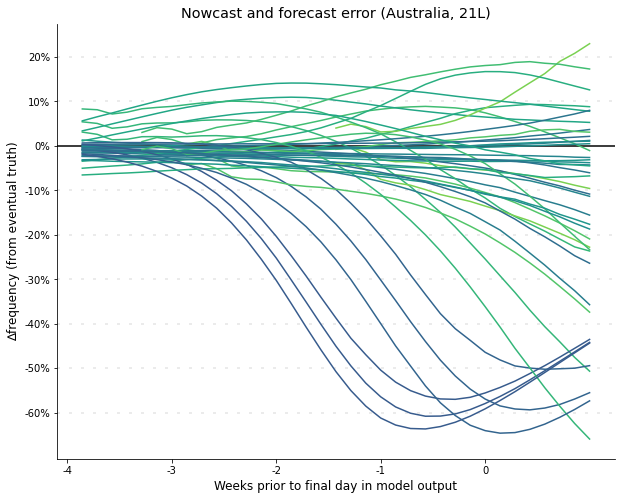

In [126]:
def plot_nowcast_error(ax, data, title, ymin=False, ymax=False):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for colname in data.columns:
        if colname == 't':
            continue
        commit_short = colname.split('_')[-1]
        c = colours[commit_short]
        ax.plot(data["t"], data[colname], color=c, zorder=2)

    ## construct x-ticks to be weeks:
    xtickvals = [0]
    while xtickvals[-1]>data['t'].iloc[0]:
        xtickvals.append(xtickvals[-1]-7)
    ax.set_xticks(xtickvals)
    ax.set_xticklabels([int(x/7) for x in xtickvals])
    ax.set_xlabel('Weeks prior to final day in model output', size='large')
    
    # y-ticks:
    if ymax is False:
        ymax = max(data.max().drop('t'))
    if ymin is False:
        ymin = min(data.min().drop('t'))
    yticks = np.linspace(-1, 1, 21) # -1, -0.9, ..., 0.9, 1
    yticks = [y for y in yticks if y<=ymax and y>=ymin]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{round(y*100)}%' for y in yticks])
    ax.set_ylabel("∆frequency (from eventual truth)", size='large')
    

    
    for y in yticks:
        if round(y,1)==0:
            ax.axhline(y=0, c='k', zorder=1)
        else:
            ax.axhline(y=y, c='k', alpha=0.1, zorder=1, dashes=[2,6])

    ax.set_title(title, size='x-large')


## plot one just to see...

fig, ax = plt.subplots(figsize=(10, 8))
df = collect_error(prepare_data("Australia", "Omicron 21L")[1]) ## subset prepare data based on 1st day?
plot_nowcast_error(ax, df, "Nowcast and forecast error (Australia, 21L)")
plt.show()

del fig, ax, df

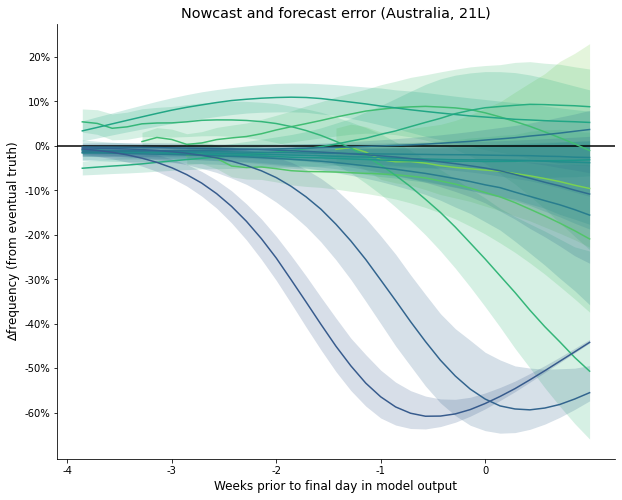

In [128]:
def plot_nowcast_error(ax, data, title, ymin=False, ymax=False):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    dates = [colname.split('_')[-1] for colname in data.columns]
    dates = np.unique(dates) 
    for date in dates:
        if date == 't':
            continue
        c = colours[date]
        med_error = data[f'error_{date}']
        upper_error = data[f'error_upper80_{date}']
        lower_error = data[f'error_lower80_{date}']
        ax.plot(data["t"], med_error, color=c, zorder=2)
        # 95% CI
        ax.fill_between(data["t"], upper_error,lower_error,
                        color=c, alpha = 0.2, lw=0, zorder=1)

    ## construct x-ticks to be weeks:
    xtickvals = [0]
    while xtickvals[-1]>data['t'].iloc[0]:
        xtickvals.append(xtickvals[-1]-7)
    ax.set_xticks(xtickvals)
    ax.set_xticklabels([int(x/7) for x in xtickvals])
    ax.set_xlabel('Weeks prior to final day in model output', size='large')
    
    # y-ticks:
    if ymax is False:
        ymax = max(data.max().drop('t'))
    if ymin is False:
        ymin = min(data.min().drop('t'))
    yticks = np.linspace(-1, 1, 21) # -1, -0.9, ..., 0.9, 1
    yticks = [y for y in yticks if y<=ymax and y>=ymin]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{round(y*100)}%' for y in yticks])
    ax.set_ylabel("∆frequency (from eventual truth)", size='large')
    

    
    for y in yticks:
        if round(y,1)==0:
            ax.axhline(y=0, c='k', zorder=1)
        else:
            ax.axhline(y=y, c='k', alpha=0, zorder=1, dashes=[2,6])

    ax.set_title(title, size='x-large')


## plot one just to see...

fig, ax = plt.subplots(figsize=(10, 8))
df = collect_error(prepare_data("Australia", "Omicron 21L")[1]) ## subset prepare data based on 1st day?
plot_nowcast_error(ax, df, "Nowcast and forecast error (Australia, 21L)")
plt.show()

del fig, ax, df

In [129]:
def prepare_multiple(locations, variant):
    """
    Helper fn to return a list of prepared datasets, one per location.
    Dates before the first with any non-trivial frequencies are removed
    """
    datasets = [prepare_data(location, variant) for location in locations]
    first_day = sorted([d[0] for d in datasets])[0] ## different for each column, but consistent within a column
    print(f"Earliest day for {variant} across {len(locations)} locations: {first_day}")
    ## remove data before the first day when any location had non-trivial frequencies
    datasets = [d[1][d[1].apply(lambda row: row['date']>=first_day, axis=1)] for d in datasets]
    return datasets

Earliest day for Omicron 21L across 2 locations: 2022-01-23


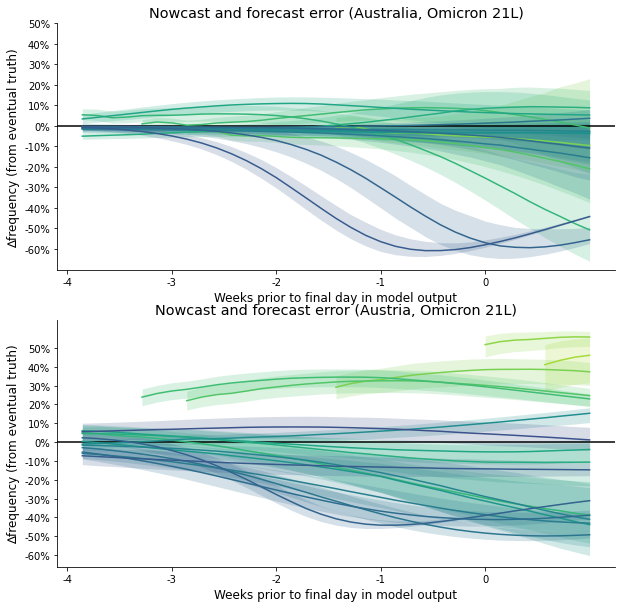

In [131]:
locations = ["Australia", "Austria"]
variant = "Omicron 21L"
datasets = prepare_multiple(locations, variant)
errors = [collect_error(df) for df in datasets]
ymin = min([min(df.min().drop('t')) for df in errors])
ymax = max([max(df.max().drop('t')) for df in errors])

fig, axes = plt.subplots(nrows=len(locations), figsize=(10, 5*len(locations)))
fig.patch.set_facecolor('white')

for idx, ax in enumerate(axes):
    location = locations[idx]
    plot_nowcast_error(ax, errors[idx], f"Nowcast and forecast error ({location}, {variant})", ymin=ymin, ymax=ymax)
                     
plt.savefig(f'nowcast_nowcast_error.{variant.split()[-1]}.png', format="png", bbox_inches='tight', transparent=False, pad_inches=0)

plt.show()